# 巴菲特企業投資法則選股策略

本策略分成以下兩部分：
- 運用 TejToolAPI 抓取巴菲特選股策略所需之財務面日資料，將資料進行整理後，找出符合選股策略的標的。
- 運用 TQuant Lab 將標的進行買進持有一年 (2023-01-01 至 2023-12-31)，觀察其風險與報酬表現。

巴菲特 5 大選股條件如下：
1. 最近年度股東權益報酬率 ＞ 平均值 (市場及產業)
2. 3 年平均股東權益報酬率＞15%
3. 最近年度毛利率 ＞ 產業平均值
4. 7 年內市值增加值 / 7 年內保留盈餘增加值 > 1
5.  ( 最近年度自由現金流量 / 7 年前自由現金流量 ) - 1 > 1

## 設定基本套件與環境

``` python
os.environ['TEJAPI_KEY'] = tej_key    ==> 個人 api key 以驗證身分。
os.environ['TEJAPI_BASE'] = api_base  ==> 導航至 tej api 網域。
```

In [1]:
import os
import numpy as np
import pandas as pd

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

## 使用 `get_universe()` 函式取得股票池
`get_universe()` 函數可以幫助我們抓取特定的股票池（市場、板塊、證券種類、產業）。  
比較每一元保留盈餘是否創造超過一元的市場價值時，由於牽涉到公司上市年限是否夠久，我們選取上市期間大於 7 年的公司。  
另外，因為 ROE 可以藉由舉債來提升，因此我們排除金融產業這類高槓桿的產業。

p.s. 關於 `get_universe()` 的說明，可參考 TQuant Lab github：[get_universe 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/get_universe%E8%AA%AA%E6%98%8E.ipynb)

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2015-12-31', 
                    end = '2015-12-31',  # 選取 2015 年年底已上市的股票
                    mkt_bd_e = 'TSE',  # 已上市之股票
                    stktp_e = 'Common Stock',  # 普通股 
                    main_ind_e = 'General Industry') # general industry 可篩掉金融產業
pool

Currently used TEJ API key call quota 580/100000 (0.58%)
Currently used TEJ API key data quota 18472453/10000000 (184.72%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1469',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 

In [3]:
len(pool)

790

## 利用 TejToolAPI 抓取所需的財務資料
根據上述選股條件，我們需要的財務科目有以下 7 項：
1. 主產業別_中文
2. 常續ROE
3. 營業毛利率
4. 個股市值_元
5. 保留盈餘
6. 營運產生現金流量
7. 投資產生現金流量

註： 
- TejToolAPI 的詳細使用方法可參考 TQuant Lab github：[TejToolAPI 說明](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Data%20Preprocess%20-%20tejtoolapi.ipynb)
- TejToolAPI 提供之資料集可參考 TQuant Lab 官網：[TQuant Lab 資料集](https://tquant.tejwin.com/%e8%b3%87%e6%96%99%e9%9b%86/)

In [4]:
import TejToolAPI

start_time = pd.Timestamp('2015-12-31')
end_time = pd.Timestamp('2022-12-30')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool,
                                   fin_type = 'A', # 為累計資料，舉例來說，Q3累計：1月～9月的資料。
                                   columns = ['主產業別_中文', '常續ROE', '營業毛利率', '個股市值_元', '保留盈餘', '營運產生現金流量', '投資產生現金流量'],
                                   transfer_to_chinese = True)

data['個股市值(千)'] = data['個股市值_元'] / 1000  # 將個股市值的單位改為(千)
data['自由現金流量'] = data['營運產生現金流量_A'] + data['投資產生現金流量_A']  # 計算自由現金流量 = 營運產生現金流量 + (-)投資產生現金流量
data.drop(columns = ['個股市值_元', '營運產生現金流量_A', '投資產生現金流量_A'], inplace = True)  # 移除欄位

data

Currently used TEJ API key call quota 663/100000 (0.66%)
Currently used TEJ API key data quota 22715478/10000000 (227.15%)


,股票代碼,日期,主產業別_中文,營業毛利率_A,常續ROE_A,保留盈餘_A,個股市值(千),自由現金流量
0,1101,2015-12-31,M1100 水泥工業,14.59,2.46,44337361.0,100796401.0,8286548.0
1,1101,2016-01-04,M1100 水泥工業,14.59,2.46,44337361.0,96550399.0,8286548.0
2,1101,2016-01-05,M1100 水泥工業,14.59,2.46,44337361.0,97473443.0,8286548.0
3,1101,2016-01-06,M1100 水泥工業,14.59,2.46,44337361.0,96181181.0,8286548.0
4,1101,2016-01-07,M1100 水泥工業,14.59,2.46,44337361.0,100981010.0,8286548.0
...,...,...,...,...,...,...,...,...
1319027,9958,2022-12-26,M2000 鋼鐵工業,10.79,4.35,1913701.0,20032571.0,-686003.0
1319028,9958,2022-12-27,M2000 鋼鐵工業,10.79,4.35,1913701.0,20450885.0,-686003.0
1319029,9958,2022-12-28,M2000 鋼鐵工業,10.79,4.35,1913701.0,21357231.0,-686003.0
1319030,9958,2022-12-29,M2000 鋼鐵工業,10.79,4.35,1913701.0,21101595.0,-686003.0


## 選股條件 1：最近年度股東權益報酬率＞產業平均值

In [5]:
# 取出最近年度(2022-12-30)的資料
data_last_1Y = data[data['日期'] == '2022-12-30'].reset_index(drop = True) 

# 取出股票基本資料與 ROE 資料方便觀察
ROE_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '常續ROE_A']]

# 依不同產業分類，計算出產業平均 ROE
industry_ROE_ave = ROE_1Y_data.groupby('主產業別_中文')['常續ROE_A'].transform('mean')

# 加入 '產業平均ROE' 欄位
ROE_1Y_data['產業平均ROE'] = industry_ROE_ave
 
ROE_1Y_data

,股票代碼,日期,主產業別_中文,常續ROE_A,產業平均ROE
0,1101,2022-12-30,M1100 水泥工業,-0.07,2.777143
1,1102,2022-12-30,M1100 水泥工業,5.60,2.777143
2,1103,2022-12-30,M1100 水泥工業,-1.32,2.777143
3,1104,2022-12-30,M1100 水泥工業,5.10,2.777143
4,1108,2022-12-30,M1100 水泥工業,6.30,2.777143
...,...,...,...,...,...
746,9944,2022-12-30,M9900 其他,1.94,7.694038
747,9945,2022-12-30,M9900 其他,22.26,7.694038
748,9946,2022-12-30,M2500 建材營造,1.51,6.178400
749,9955,2022-12-30,M9900 其他,-5.44,7.694038


In [6]:
# 篩選符合選股條件的標的
set_1 = set(ROE_1Y_data[ROE_1Y_data['常續ROE_A'] > ROE_1Y_data['產業平均ROE']]['股票代碼'])

In [7]:
len(set_1)

368

## 選股條件 2：3年平均股東權益報酬率＞15%

In [8]:
# 取出近三年(2022-12-30, 2021-12-30, 2020-12-30)的資料
data_last_3Y = data[data['日期'].isin(['2022-12-30', '2021-12-30', '2020-12-30'])].reset_index(drop = True)

# 計算公司三年平均的 ROE
ROE_3Y_ave = data_last_3Y.groupby('股票代碼')['常續ROE_A'].mean()

# 從 Series 轉成 Dataframe，並重新命名欄位
ROE_3Y_ave = pd.DataFrame(ROE_3Y_ave).rename(columns = {'常續ROE_A': '3年平均ROE'})

ROE_3Y_ave

,3年平均ROE
股票代碼,
1101,5.280000
1102,6.776667
1103,-2.246667
1104,3.960000
1108,5.650000
...,...
9944,1.683333
9945,14.920000
9946,2.293333


In [9]:
# 篩選符合選股條件的標的
set_2 = set(ROE_3Y_ave[ROE_3Y_ave['3年平均ROE'] > 15].index)  

In [10]:
len(set_2)

83

## 選股條件 3：最近年度毛利率＞產業平均值

In [11]:
# 取出股票基本資料與 Gross Margin 資料方便觀察
GM_1Y_data = data_last_1Y[['股票代碼', '日期', '主產業別_中文', '營業毛利率_A']]

# 依不同產業分類，計算出產業平均 GM
industry_GM_ave = GM_1Y_data.groupby('主產業別_中文')['營業毛利率_A'].transform('mean')  

# 加入 '產業平均毛利率' 欄位
GM_1Y_data['產業平均毛利率'] = industry_GM_ave

GM_1Y_data

,股票代碼,日期,主產業別_中文,營業毛利率_A,產業平均毛利率
0,1101,2022-12-30,M1100 水泥工業,5.55,12.614286
1,1102,2022-12-30,M1100 水泥工業,14.83,12.614286
2,1103,2022-12-30,M1100 水泥工業,3.44,12.614286
3,1104,2022-12-30,M1100 水泥工業,18.49,12.614286
4,1108,2022-12-30,M1100 水泥工業,19.85,12.614286
...,...,...,...,...,...
746,9944,2022-12-30,M9900 其他,26.99,26.303269
747,9945,2022-12-30,M9900 其他,22.23,26.303269
748,9946,2022-12-30,M2500 建材營造,16.70,27.686800
749,9955,2022-12-30,M9900 其他,0.01,26.303269


In [12]:
# 篩選符合選股條件的標的
set_3 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業平均毛利率']]['股票代碼'])

In [13]:
len(set_3)

346

## 選股條件 4：7年內市值增加值 / 7年內保留盈餘增加值 > 1

In [14]:
# 取出最近一年及七年前的資料
MV_RE_data = data[data['日期'].isin(['2015-12-31', '2022-12-30'])].reset_index(drop = True)  # 取出最近一年及七年前的資料

# 取出股票基本資料與市值、保留盈餘方便觀察
MV_RE_data = MV_RE_data[['股票代碼', '日期', '個股市值(千)', '保留盈餘_A']]  

# 計算個股市值增加值
MV_RE_data['個股市值增加值'] = MV_RE_data.groupby('股票代碼')['個股市值(千)'].diff()

# 計算保留盈餘增加值
MV_RE_data['保留盈餘增加值'] = MV_RE_data.groupby('股票代碼')['保留盈餘_A'].diff()

# 計算'指標'： 7年內市值增加值 / 7年內保留盈餘增加值
MV_RE_data['指標'] = MV_RE_data['個股市值增加值'] / MV_RE_data['保留盈餘增加值']

MV_RE_data

,股票代碼,日期,個股市值(千),保留盈餘_A,個股市值增加值,保留盈餘增加值,指標
0,1101,2015-12-31,100796401.0,44337361.0,NaN,NaN,NaN
1,1101,2022-12-30,240805516.0,64275022.0,140009115.0,19937661.0,7.022344
2,1102,2015-12-31,92103653.0,91900694.0,NaN,NaN,NaN
3,1102,2022-12-30,145383030.0,114375109.0,53279377.0,22474415.0,2.370668
4,1103,2015-12-31,7375911.0,7756185.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1536,9946,2022-12-30,3983961.0,2907800.0,443286.0,1687667.0,0.262662
1537,9955,2015-12-31,1295263.0,137930.0,NaN,NaN,NaN
1538,9955,2022-12-30,2043523.0,-551937.0,748260.0,-689867.0,-1.084644
1539,9958,2015-12-31,1855581.0,369088.0,NaN,NaN,NaN


In [15]:
# 篩選符合選股條件的標的
set_4 = set(MV_RE_data[MV_RE_data['指標'] > 1]['股票代碼'])  

In [16]:
len(set_4)

442

## 選股條件 5：(最近年度自由現金流量 / 7年前自由現金流量) - 1 >= 1

In [17]:
# 取出最近一年及七年前的資料
cash_data = data[data['日期'].isin(['2015-12-31', '2022-12-30'])].reset_index(drop = True)  

# 取出股票基本資料與自由現金流量方便觀察
cash_data = cash_data[['股票代碼', '日期', '自由現金流量']]  

# 計算自由現金流量比率： 最近年度自由現金流量 / 7年前自由現金流量
cash_data['自由現金流量比率'] = cash_data['自由現金流量'] / cash_data.groupby('股票代碼')['自由現金流量'].shift(1)

# 計算'指標'： 自由現金流量比率 - 1
cash_data['指標'] = cash_data['自由現金流量比率'] - 1

cash_data

,股票代碼,日期,自由現金流量,自由現金流量比率,指標
0,1101,2015-12-31,8286548.0,NaN,NaN
1,1101,2022-12-30,-7925014.0,-0.956371,-1.956371
2,1102,2015-12-31,9197717.0,NaN,NaN
3,1102,2022-12-30,13823534.0,1.502931,0.502931
4,1103,2015-12-31,-2602574.0,NaN,NaN
...,...,...,...,...,...
1536,9946,2022-12-30,554326.0,0.548796,-0.451204
1537,9955,2015-12-31,-64874.0,NaN,NaN
1538,9955,2022-12-30,-28051.0,0.432392,-0.567608
1539,9958,2015-12-31,243795.0,NaN,NaN


In [18]:
# 篩選符合選股條件的標的
set_5 = set(cash_data[cash_data['指標'] > 1]['股票代碼'])  

In [19]:
len(set_5)

179

## 取出符合所有條件的股票

In [20]:
tickers = list(set_1 & set_2 & set_3 & set_4 & set_5)
tickers

['3014',
 '8046',
 '8081',
 '3413',
 '3034',
 '3006',
 '3533',
 '5269',
 '6202',
 '8016',
 '3557',
 '1477',
 '3042',
 '5234',
 '1476',
 '2467',
 '9906']

In [21]:
len(tickers)

17

## 查看標的證券名稱與產業

In [22]:
import tejapi

tejapi.ApiConfig.api_key = tej_key
tejapi.ApiConfig.ignoretz = api_base

ticker_data = tejapi.get('TWN/APISTOCK',  # 證券屬性資料表
                  coid = tickers,
                  opts = {'columns':['coid', 'stk_name', 'tseindnm_c']},
                  chinese_column_name = True,
                  paginate = True)

ticker_data

,公司簡稱,證券名稱,交易所產業名稱
None,,,
0,1476,儒鴻,紡織纖維
1,1477,聚陽,紡織纖維
2,2467,志聖,電子零組件業
3,3006,晶豪科,半導體業
4,3014,聯陽,半導體業
5,3034,聯詠,半導體業
6,3042,晶技,電子零組件業
7,3413,京鼎,半導體業
8,3533,嘉澤,電子零組件業


## 整合每間公司符合哪些選股條件

In [23]:
company_list = data['股票代碼'].unique().tolist()
coid = {'公司代碼': company_list}

data_combine = pd.DataFrame(coid)
data_combine['選股條件 1'] = data_combine['公司代碼'].isin(set_1)
data_combine['選股條件 2'] = data_combine['公司代碼'].isin(set_2)
data_combine['選股條件 3'] = data_combine['公司代碼'].isin(set_3)
data_combine['選股條件 4'] = data_combine['公司代碼'].isin(set_4)
data_combine['選股條件 5'] = data_combine['公司代碼'].isin(set_5)
data_combine['符合條件數量'] = data_combine.iloc[:, 1:6].sum(axis = 1)

data_combine

,公司代碼,選股條件 1,選股條件 2,選股條件 3,選股條件 4,選股條件 5,符合條件數量
0,1101,False,False,False,True,False,1
1,1102,True,False,True,True,False,3
2,1103,False,False,False,True,False,1
3,1104,True,False,True,False,True,3
4,1108,True,False,True,False,False,2
...,...,...,...,...,...,...,...
785,9944,False,False,True,False,True,2
786,9945,True,False,False,True,False,2
787,9946,False,False,False,False,False,0
788,9955,False,False,False,False,False,0


## 利用 TQuant Lab 回測股票池買進持有 1 年的績效

### 導入股價資料
在 zipline 中，我們使用 `os` 搭配 `!zipline ingest` 將股價資料導入到本地端。常用寫法為:
``` python
!zipline ingest -b tqant
```
在 ingest 之前，需先使用 `os` 設定環境變數，
``` python
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'  
# IR0001 為加權股價報酬指數，通常用來當作回測 benchmark。
```

In [24]:
start = '2023-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 669/100000 (0.67%)
Currently used TEJ API key data quota 23079252/10000000 (230.79%)


[2024-02-22 05:52:10.159966] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-02-22 05:52:12.984603] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### Initialize 函式

`initialize` 為構建 zipline 交易策略的重要函式，會在回測開始前被呼叫一次，主要任務為設定回測環境，常見用於設定滑價或手續費。  
zipline 提供四種滑價計算方法與三種手續費計算方法。於此範例中，我們使用 `VolumeShareSlippage` 計算滑價、`Custom_TW_Commission` 計算手續費。

註：
- 滑價設定方法可參考： TQuant Lab github：[zipline slippage model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Slippage.ipynb)
- 手續費設定方法可參考： TQuant Lab github：[zipline commission model](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Commission%20Models.ipynb)

除此之外，我們可以注意到 initialize 含有一個參數 **context__**，**context__** 為一個命名空間 (namespace)，可以在儲存各種自定義之變數並且在每次交易日中循環呼叫。  舉例來說，我們設置一個變數 (context.day = 0) 來計算交易日天數與一個變數 (context.tickers = tickers) 紀錄股票標的。

In [25]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))

### Handle_data 函式

`handle_data` 為構建 zipline 交易策略的重要函式，會在回測開始後每天被呼叫，主要任務為設定交易策略、下單與紀錄交易資訊。  
在此範例中，我們加入下單函式 `order_percent`，用以將資產均分購買股票池中的股票。 

註：
- `order_percent` 使用方法可參考： TQuant Lab github：[Zipline Order (percent & target_percent)](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Zipline%20Order%20(percent%20%26%20target_percent).ipynb)

In [26]:
def handle_data(context, data):

    # 回測第一天買進
    if context.day == 0:
        for ticker in context.tickers:
            order_percent(symbol(ticker), 1 / len(tickers))

    context.day += 1  # 以免重複買進，並紀錄交易天數

### Analyze 函式

`analyze` 主要用於回測後視覺化策略績效與風險，這裡我們以 `matplotlib` 繪製投組價值與大盤走勢的比較圖。  
其中 `analyze` 有兩個參數 **context** 與 **results**，**context** 就與上述相同，用以紀錄交易訊息，**results** 就是最終 ``run_algorithm`` 輸出的資料表 -- *results*。我們可以提取裡面特定欄位來繪製圖表。

In [27]:
import matplotlib.pyplot as plt

capital_base = 1e7  # 設定初始資金

def analyze(context, results):

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

### Run_algorithm 函式

進行策略回測。

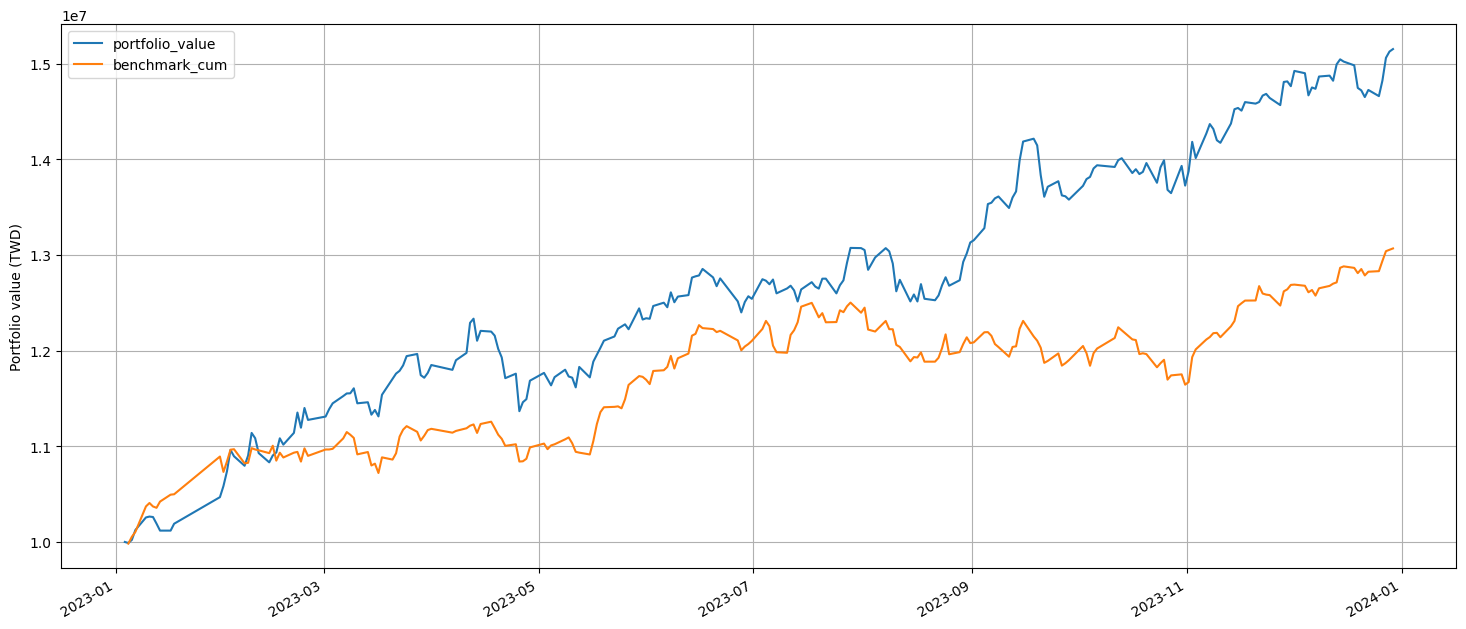

,period_open,period_close,transactions,pnl,ending_exposure,positions,net_leverage,starting_value,returns,ending_value,...,alpha,beta,sharpe,sortino,treasury_period_return,benchmark_period_return,excess_return,benchmark_volatility,period_label,benchmark_cum
2023-01-03 13:30:00+08:00,2023-01-03 09:01:00+08:00,2023-01-03 13:30:00+08:00,[],0.000000,0.00,[],0.000000,0.00,0.000000,0.00,...,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,2023-01,NaN
2023-01-04 13:30:00+08:00,2023-01-04 09:01:00+08:00,2023-01-04 13:30:00+08:00,"[{'amount': 7927, 'dt': 2023-01-04 13:30:00+08...",-11327.676790,7872407.00,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.788133,0.00,-0.001133,7872407.00,...,NaN,NaN,-11.224972,-11.224972,0.0,-0.001741,0.000608,NaN,2023-01,9.982590e+06
2023-01-05 13:30:00+08:00,2023-01-05 09:01:00+08:00,2023-01-05 13:30:00+08:00,"[{'amount': 650, 'dt': 2023-01-05 13:30:00+08:...",33131.401719,8087383.25,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.806979,7872407.00,0.003317,8087383.25,...,-0.064409,0.498900,4.997876,17.671655,0.0,0.005424,-0.003244,0.100115,2023-01,1.005424e+07
2023-01-06 13:30:00+08:00,2023-01-06 09:01:00+08:00,2023-01-06 13:30:00+08:00,"[{'amount': 225, 'dt': 2023-01-06 13:30:00+08:...",102932.271094,8484020.35,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.837950,8087383.25,0.010271,8484020.35,...,0.423236,0.786389,9.632694,87.271382,0.0,0.010506,0.001967,0.073959,2023-01,1.010506e+07
2023-01-09 13:30:00+08:00,2023-01-09 09:01:00+08:00,2023-01-09 13:30:00+08:00,"[{'amount': 550, 'dt': 2023-01-09 13:30:00+08:...",131373.451562,8927034.25,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.870411,8484020.35,0.012975,8927034.25,...,0.845308,0.425879,12.895727,159.378076,0.0,0.037143,-0.011532,0.191248,2023-01,1.037143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,[],-64226.400000,13994791.40,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.954578,14059017.80,-0.004362,13994791.40,...,0.226348,0.796750,2.721917,4.244580,0.0,0.283076,0.182995,0.126110,2023-12,1.283076e+07
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,[],162677.200000,14157468.60,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.955077,13994791.40,0.011096,14157468.60,...,0.230512,0.798528,2.787152,4.354836,0.0,0.293786,0.188552,0.126064,2023-12,1.293786e+07
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,[],237432.400000,14394901.00,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.955785,14157468.60,0.016017,14394901.00,...,0.240799,0.802570,2.878226,4.517427,0.0,0.303973,0.202108,0.125989,2023-12,1.303973e+07
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,[],65523.300000,14460424.30,"[{'sid': Equity(4 [3014]), 'amount': 7927, 'co...",0.955977,14394901.00,0.004351,14460424.30,...,0.244301,0.802552,2.901443,4.554489,0.0,0.305349,0.207285,0.125721,2023-12,1.305349e+07


In [28]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')  # 轉換成時間序列格式

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    bundle = 'tquant',
    capital_base = capital_base,
)

# 取出 results 中的 positions, transactions & orders 資料表
positions, transactions, orders = get_transaction_detail(results)   
results

<AxesSubplot:>

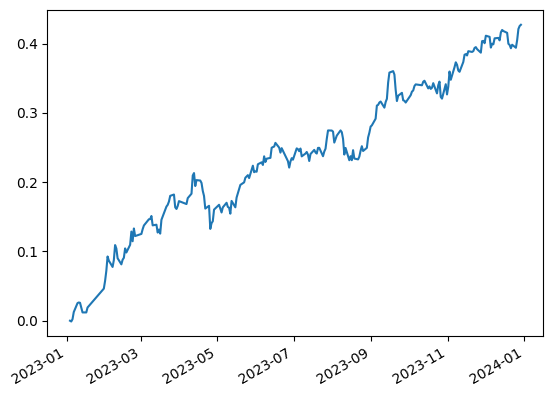

In [29]:
results.returns.cumsum().plot()  # 繪製累積回報圖

## Pyfolio

Pyfolio 與 zipline 的回測結果兼容，讓我們輕鬆用幾行程式碼，就能產出我們需要的投資風險及績效圖表。

p.s. 詳細 Pyfolio 使用方法可參考： TQuant Lab github：[Pyfolio](https://github.com/tejtw/TQuant-Lab/blob/main/lecture/Pyfolio.ipynb)

In [30]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

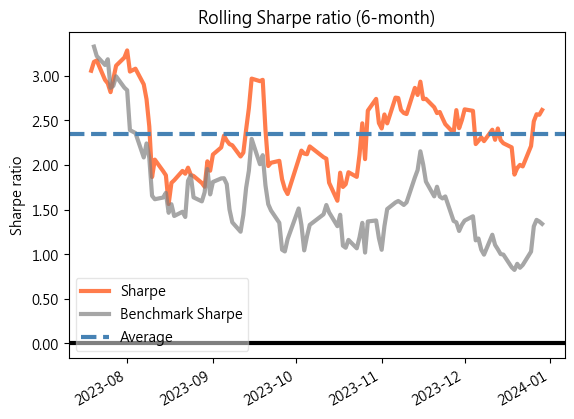

In [31]:
# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)

Start date,2023-01-03
End date,2023-12-29
Total months,11
,Backtest
Annual return,54.989%
Cumulative returns,51.525%
Annual volatility,15.497%
Sharpe ratio,2.91
Calmar ratio,7.01
Stability,0.95
Max drawdown,-7.841%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.84,2023-04-12,2023-04-25,2023-05-29,33
1,4.48,2023-09-18,2023-09-28,2023-11-06,33
2,4.28,2023-07-28,2023-08-16,2023-08-31,24
3,3.54,2023-06-16,2023-06-27,2023-07-27,28
4,2.76,2023-02-08,2023-02-13,2023-02-20,9


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.18%,-3.33%,2.73%


Top 10 long positions of all time,max
sid,
5234,10.89%
3014,10.00%
5269,9.91%
8081,7.86%
1477,7.34%
3557,7.16%
8016,6.85%
3006,6.75%
3034,6.63%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
5234,10.89%
3014,10.00%
5269,9.91%
8081,7.86%
1477,7.34%
3557,7.16%
8016,6.85%
3006,6.75%
3034,6.63%


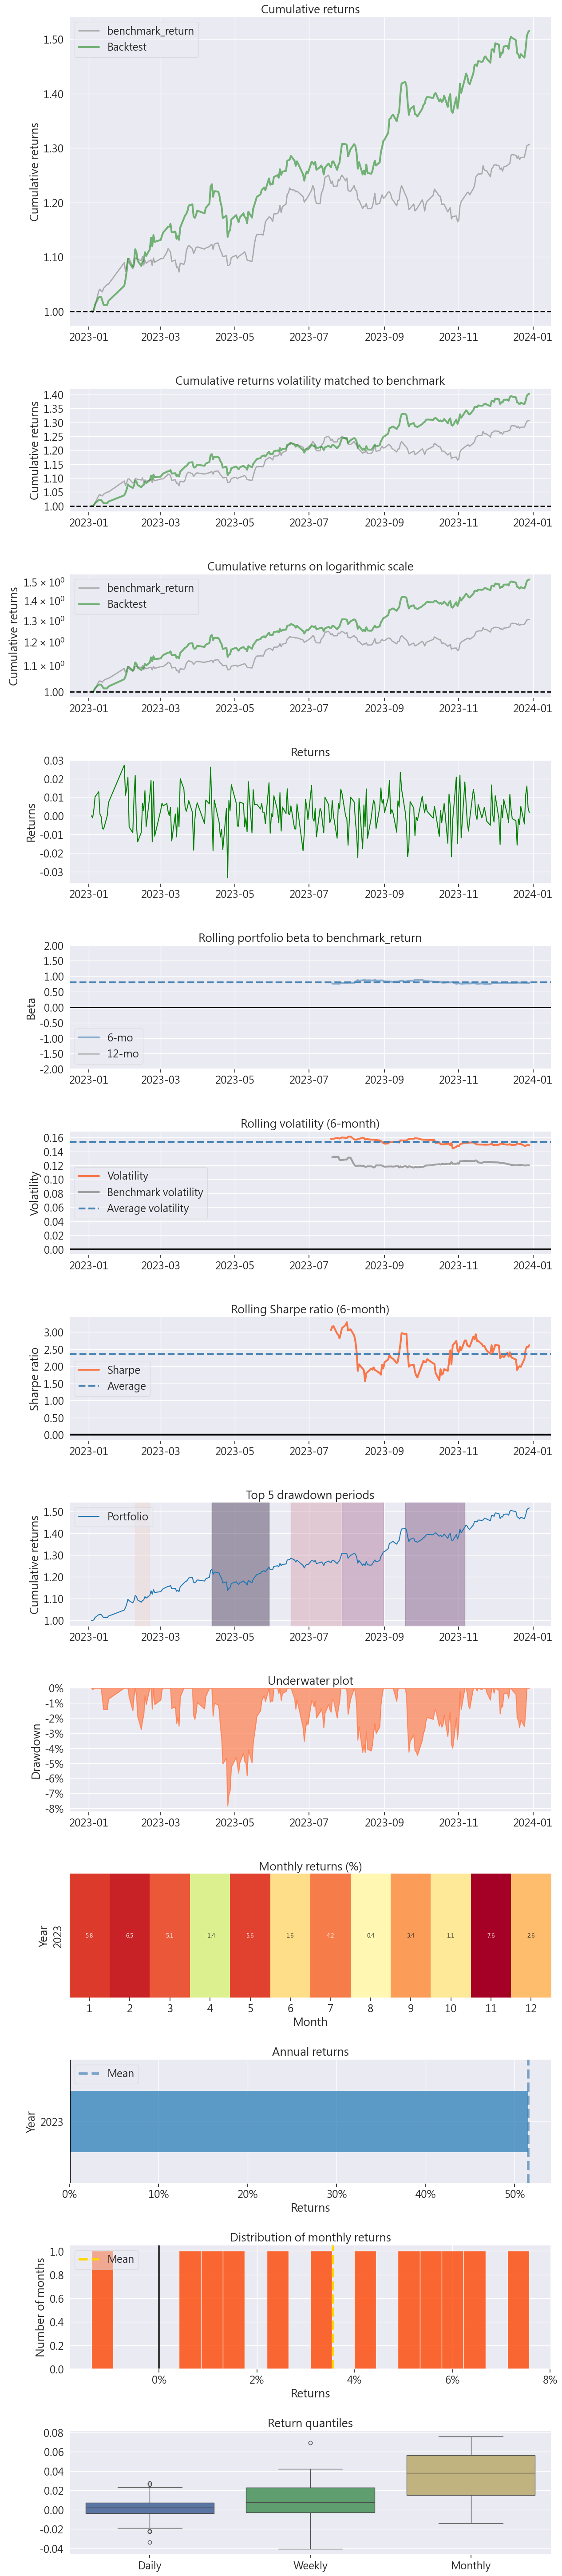

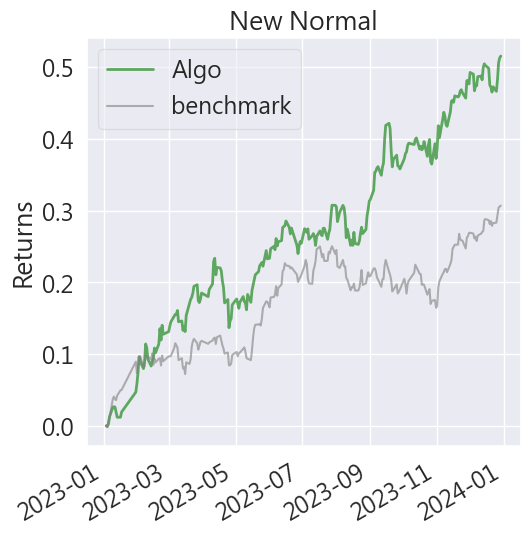

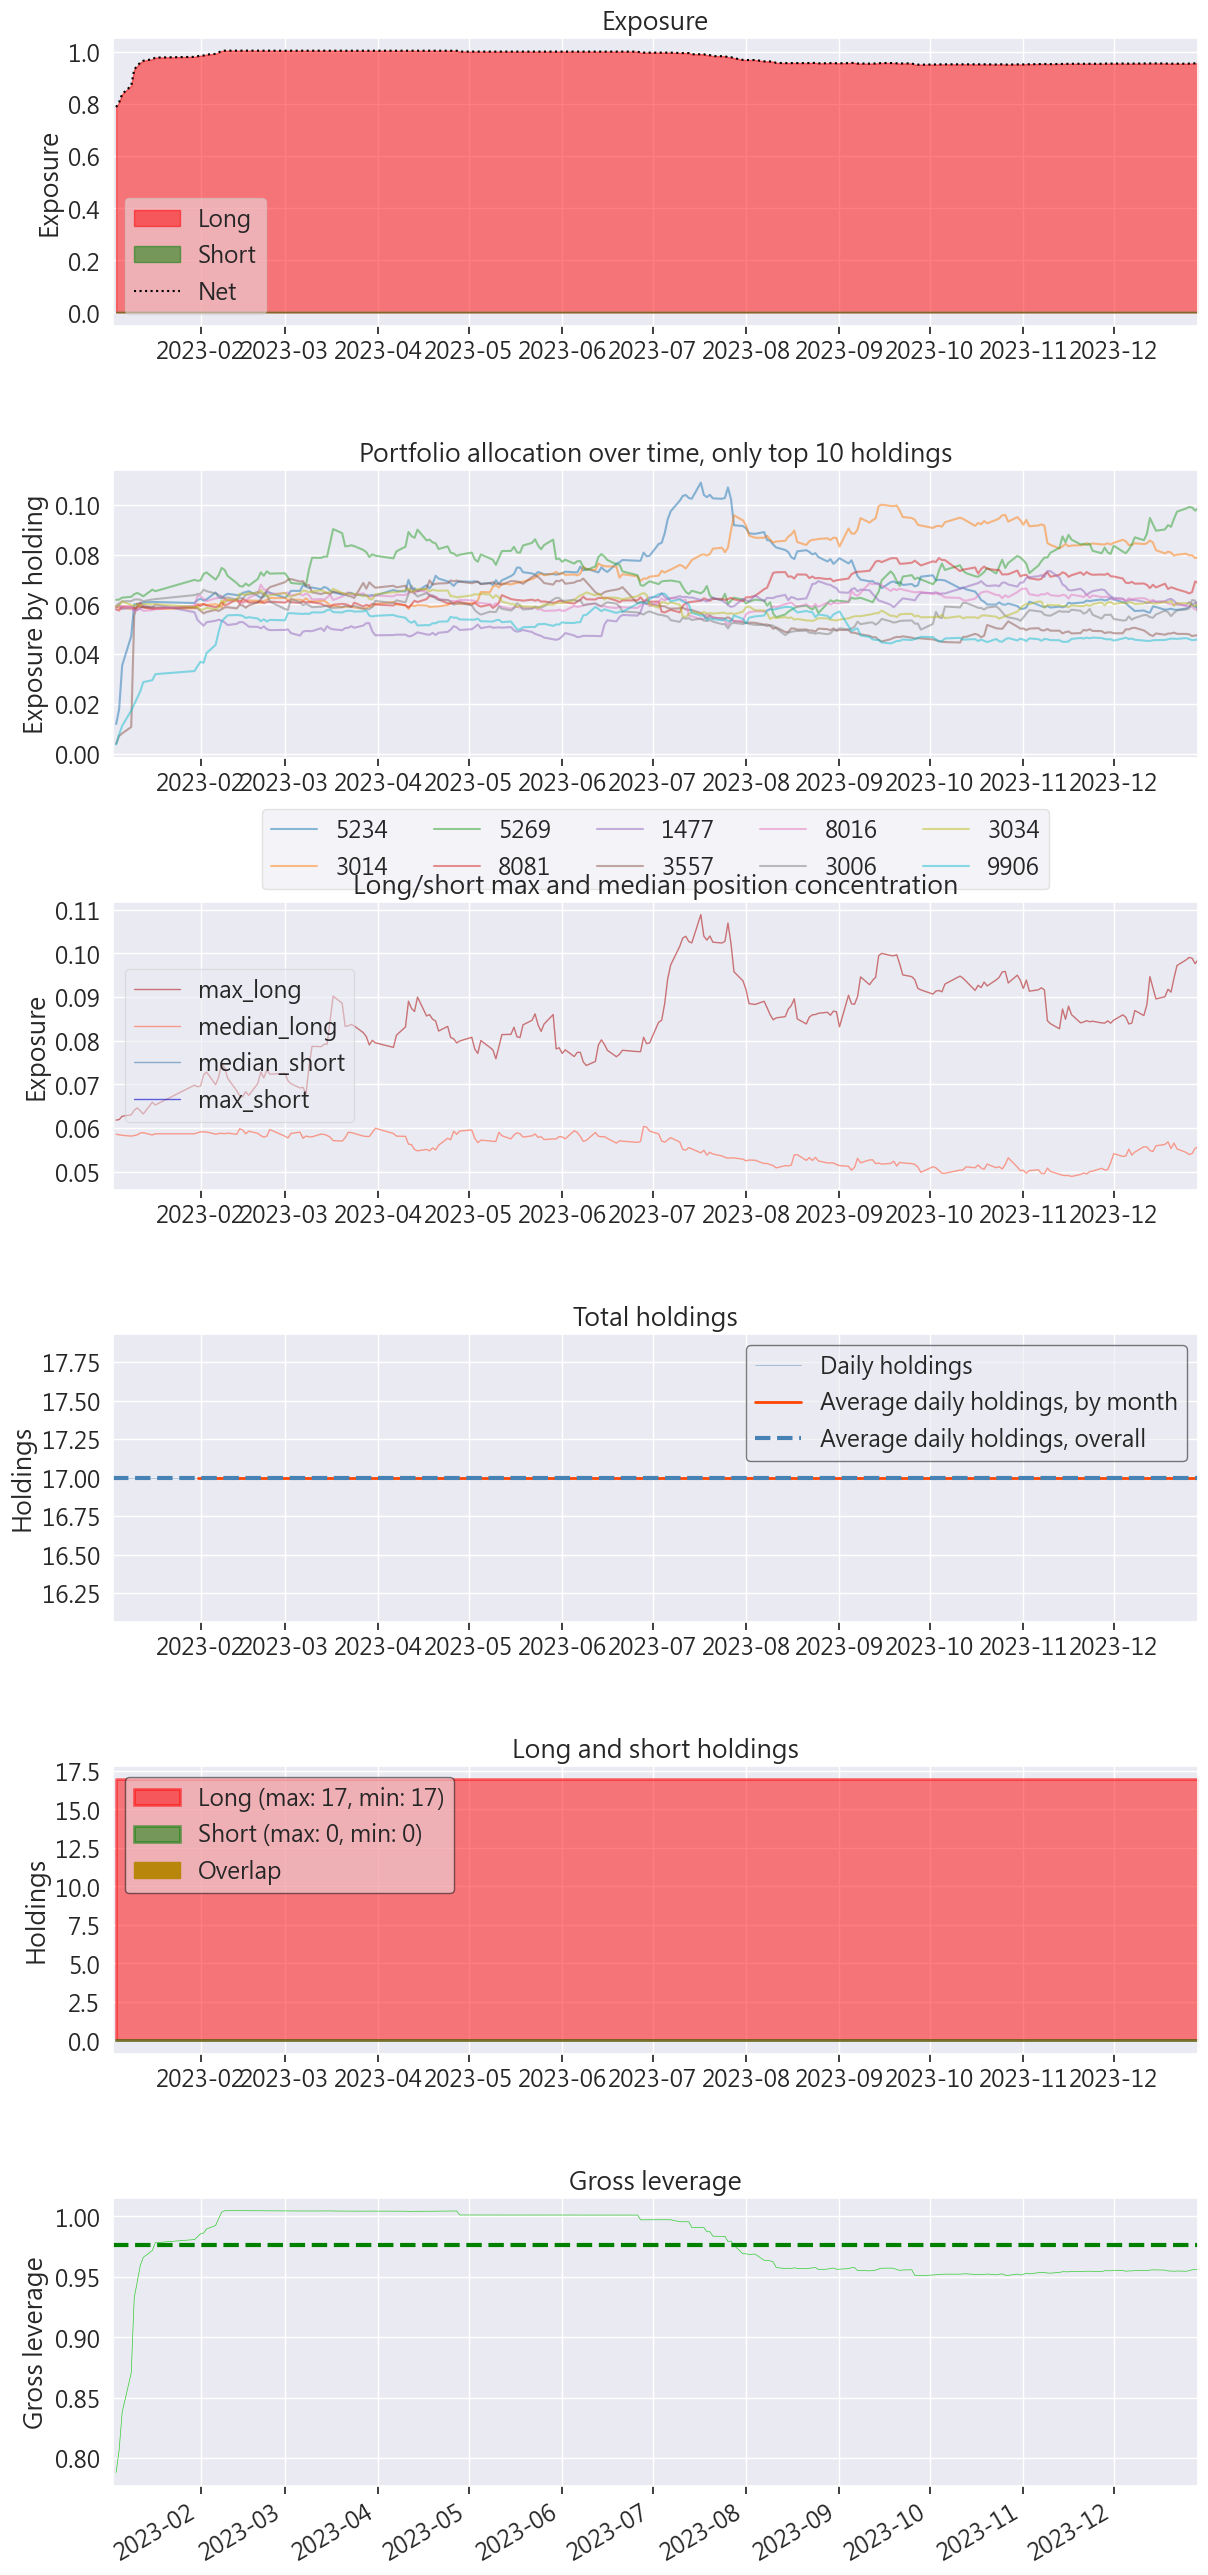

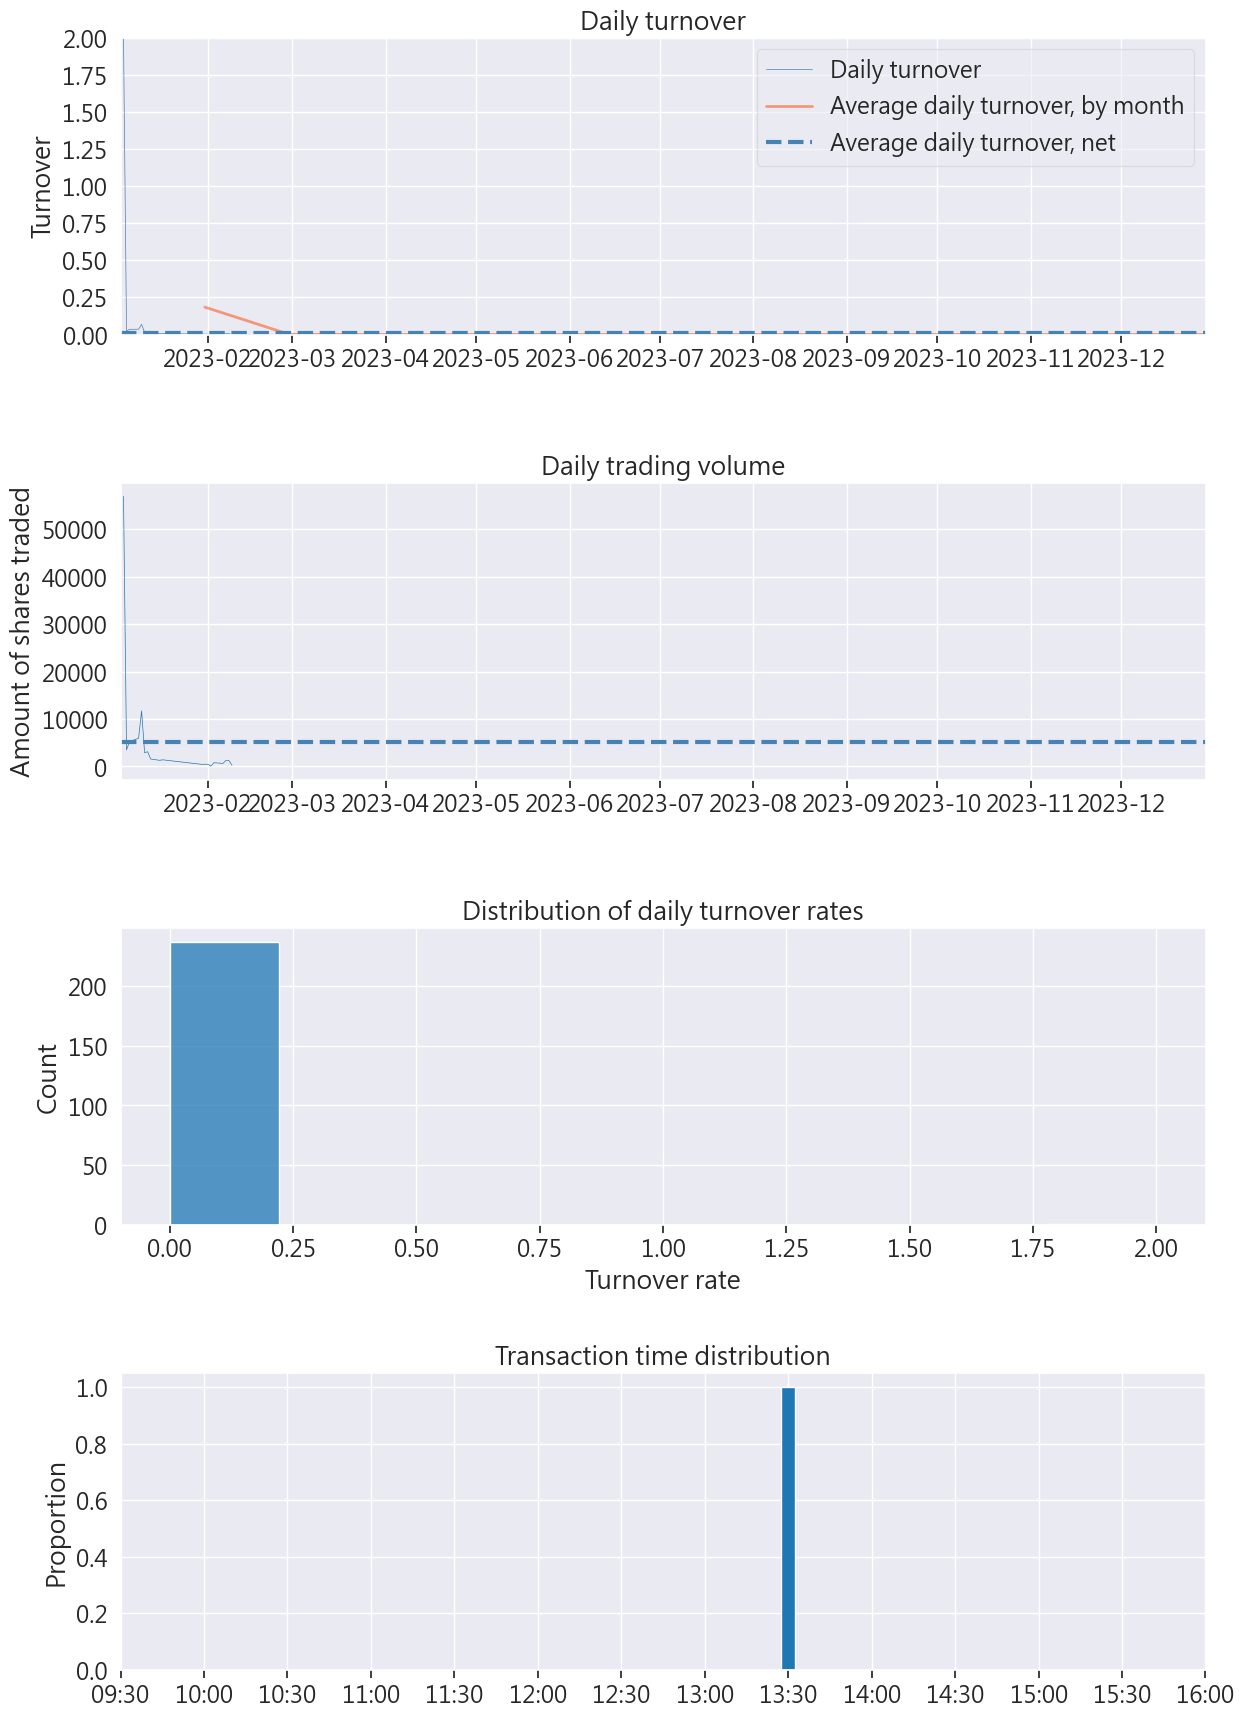

In [32]:
# 繪製 Pyfolio 中提供的所有圖表

pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )